In [1]:
import re, gensim
import pandas as pd
import numpy as np
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [2]:
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])
df_test.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [3]:
%%time
pos = [df.iloc[i]['text'] for i in range(len(df)) if df.iloc[i]['label'] == 1]
neg = [df.iloc[i]['text'] for i in range(len(df)) if df.iloc[i]['label'] == 0]
print("Positivas: {}. Negativas: {}".format(len(pos), len(neg)))
full = df['text']
full = [re.sub('(\<br \/>)+|(")|(\(*\)*)', '', _) for _ in full]
full = [re.sub('\.{2,}|[\-,;:\/?!$*\'`“\{\]]', ' ', _) for _ in full]
full = [re.sub('\.', ' ', _) for _ in full]

vocab = []
for _ in full:
    aux = _.split()
    for j in aux:
        vocab.append(j)

vocab = list(set(vocab))
print(len(vocab))

vocab_td = TaggedDocument(vocab, [1])
vocab_chido = [vocab_td]

Positivas: 12500. Negativas: 12500
98694
CPU times: total: 8.41 s
Wall time: 8.75 s


In [4]:
%%time

d2v = Doc2Vec(min_count = 1, vector_size = 300, epochs = 40)
d2v.build_vocab(vocab_chido)
d2v.train(vocab_chido, total_examples = d2v.corpus_count, epochs = d2v.epochs)

CPU times: total: 1.75 s
Wall time: 1.76 s


In [5]:
print(f"amazing aparece {d2v.wv.get_vecattr('amazing', 'count')} veces.")

amazing aparece 1 veces.


In [6]:
def processing(texto_list):
    texto_list = [re.sub('(\<br \/>)+|(")|(\(*\)*)', '', _) for _ in texto_list]
    texto_list = [re.sub('\.{2,}|[\-,;:\/?!$*\'`“\{\]]', ' ', _) for _ in texto_list]
    texto_list = [re.sub('\.', ' ', _) for _ in texto_list]
    return texto_list

def buildWordVector(model, text):
    vec = np.zeros(300).reshape((1, 300))
    count = 0.
    for word in text:
        try:
            vec += model.wv[word].reshape((1, 300))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [7]:
%%time
test_pos = [df_test.iloc[i]['text'] for i in range(len(df)) if df_test.iloc[i]['label'] == 1]
test_neg = [df_test.iloc[i]['text'] for i in range(len(df)) if df_test.iloc[i]['label'] == 0]
test_full = test_neg + test_pos
train_full = neg + pos

train = processing(train_full)
test = processing(test_full)

train_labels = np.concatenate((np.ones(len(neg)), np.zeros(len(pos))))
test_labels = np.concatenate((np.ones(len(test_neg)), np.zeros(len(test_pos))))

CPU times: total: 12 s
Wall time: 12.2 s


In [8]:
%%time
train = [buildWordVector(d2v, _) for _ in train]
train = [np.reshape(_, -1) for _ in train]
test = [buildWordVector(d2v, _) for _ in test]
test = [np.reshape(_, -1) for _ in test]

CPU times: total: 1min 22s
Wall time: 1min 24s


In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty = 'l2').fit(train, train_labels)
predictions = lr.predict(test)

In [14]:
print('Test Accuracy: %.2f'%lr.score(test, test_labels))

Test Accuracy: 0.50


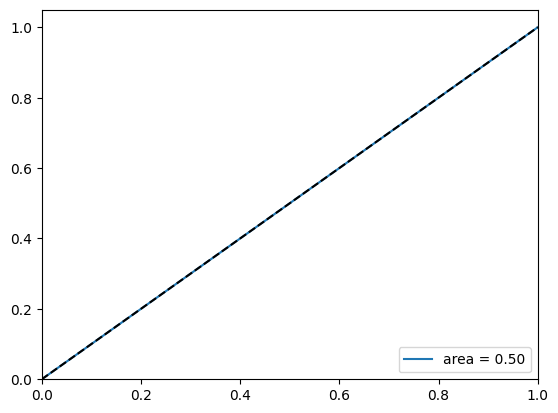

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
pred_probas = lr.predict_proba(test)[:,1]
fpr,tpr,_ = roc_curve(test_labels, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()